## WildFire Detection using Deep Learning and Transfer Learning    
https://www.tensorflow.org/hub/tutorials/tf2_image_retraining   

Deep Learning model for wildfire detection in static optical camera images

In [1]:
import sys, os, pathlib, shutil, platform
#pandas procesing tables
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, RFECV

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    roc_auc_score,
    roc_curve,
    auc,
)
from sklearn.model_selection import (
    train_test_split, 
    StratifiedShuffleSplit,
    StratifiedKFold,
)


from sklearn.preprocessing import OrdinalEncoder

from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

In [2]:
# import the library InteractiveShell
from IPython.core.interactiveshell import InteractiveShell
#"all" the instructions are printed
InteractiveShell.ast_node_interactivity = "all"

In [3]:
# ! pip install "tensorflow~=2.0"
# ! pip install "tensorflow-hub[make_image_classifier]~=0.6"
# ! make_image_classifier --help

In [4]:
import itertools

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.9.1
Hub version: 0.12.0
GPU is available


2022-08-10 19:19:21.205848: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-08-10 19:19:21.273894: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-08-10 19:19:21.274357: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [5]:
model_name = "efficientnetv2-xl-21k" 
model_name = "efficientnet_b0" 


model_handle_map = {
  "efficientnetv2-s": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/feature_vector/2",
  "efficientnetv2-m": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_m/feature_vector/2",
  "efficientnetv2-l": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_l/feature_vector/2",
  "efficientnetv2-s-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_s/feature_vector/2",
  "efficientnetv2-m-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_m/feature_vector/2",
  "efficientnetv2-l-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_l/feature_vector/2",
  "efficientnetv2-xl-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2",
  "efficientnetv2-b0-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2",
  "efficientnetv2-b1-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b1/feature_vector/2",
  "efficientnetv2-b2-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b2/feature_vector/2",
  "efficientnetv2-b3-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b3/feature_vector/2",
  "efficientnetv2-s-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_s/feature_vector/2",
  "efficientnetv2-m-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_m/feature_vector/2",
  "efficientnetv2-l-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_l/feature_vector/2",
  "efficientnetv2-xl-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_xl/feature_vector/2",
  "efficientnetv2-b0-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/feature_vector/2",
  "efficientnetv2-b1-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b1/feature_vector/2",
  "efficientnetv2-b2-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b2/feature_vector/2",
  "efficientnetv2-b3-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b3/feature_vector/2",
  "efficientnetv2-b0": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2",
  "efficientnetv2-b1": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b1/feature_vector/2",
  "efficientnetv2-b2": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b2/feature_vector/2",
  "efficientnetv2-b3": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b3/feature_vector/2",
  "efficientnet_b0": "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",
  "efficientnet_b1": "https://tfhub.dev/tensorflow/efficientnet/b1/feature-vector/1",
  "efficientnet_b2": "https://tfhub.dev/tensorflow/efficientnet/b2/feature-vector/1",
  "efficientnet_b3": "https://tfhub.dev/tensorflow/efficientnet/b3/feature-vector/1",
  "efficientnet_b4": "https://tfhub.dev/tensorflow/efficientnet/b4/feature-vector/1",
  "efficientnet_b5": "https://tfhub.dev/tensorflow/efficientnet/b5/feature-vector/1",
  "efficientnet_b6": "https://tfhub.dev/tensorflow/efficientnet/b6/feature-vector/1",
  "efficientnet_b7": "https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1",
  "bit_s-r50x1": "https://tfhub.dev/google/bit/s-r50x1/1",
  "inception_v3": "https://tfhub.dev/google/imagenet/inception_v3/feature-vector/4",
  "inception_resnet_v2": "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature-vector/4",
  "resnet_v1_50": "https://tfhub.dev/google/imagenet/resnet_v1_50/feature-vector/4",
  "resnet_v1_101": "https://tfhub.dev/google/imagenet/resnet_v1_101/feature-vector/4",
  "resnet_v1_152": "https://tfhub.dev/google/imagenet/resnet_v1_152/feature-vector/4",
  "resnet_v2_50": "https://tfhub.dev/google/imagenet/resnet_v2_50/feature-vector/4",
  "resnet_v2_101": "https://tfhub.dev/google/imagenet/resnet_v2_101/feature-vector/4",
  "resnet_v2_152": "https://tfhub.dev/google/imagenet/resnet_v2_152/feature-vector/4",
  "nasnet_large": "https://tfhub.dev/google/imagenet/nasnet_large/feature_vector/4",
  "nasnet_mobile": "https://tfhub.dev/google/imagenet/nasnet_mobile/feature_vector/4",
  "pnasnet_large": "https://tfhub.dev/google/imagenet/pnasnet_large/feature_vector/4",
  "mobilenet_v2_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4",
  "mobilenet_v2_130_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/4",
  "mobilenet_v2_140_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4",
  "mobilenet_v3_small_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5",
  "mobilenet_v3_small_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_075_224/feature_vector/5",
  "mobilenet_v3_large_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5",
  "mobilenet_v3_large_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/feature_vector/5",
}

model_image_size_map = {
  "efficientnetv2-s": 384,
  "efficientnetv2-m": 480,
  "efficientnetv2-l": 480,
  "efficientnetv2-b0": 224,
  "efficientnetv2-b1": 240,
  "efficientnetv2-b2": 260,
  "efficientnetv2-b3": 300,
  "efficientnetv2-s-21k": 384,
  "efficientnetv2-m-21k": 480,
  "efficientnetv2-l-21k": 480,
  "efficientnetv2-xl-21k": 512,
  "efficientnetv2-b0-21k": 224,
  "efficientnetv2-b1-21k": 240,
  "efficientnetv2-b2-21k": 260,
  "efficientnetv2-b3-21k": 300,
  "efficientnetv2-s-21k-ft1k": 384,
  "efficientnetv2-m-21k-ft1k": 480,
  "efficientnetv2-l-21k-ft1k": 480,
  "efficientnetv2-xl-21k-ft1k": 512,
  "efficientnetv2-b0-21k-ft1k": 224,
  "efficientnetv2-b1-21k-ft1k": 240,
  "efficientnetv2-b2-21k-ft1k": 260,
  "efficientnetv2-b3-21k-ft1k": 300, 
  "efficientnet_b0": 224,
  "efficientnet_b1": 240,
  "efficientnet_b2": 260,
  "efficientnet_b3": 300,
  "efficientnet_b4": 380,
  "efficientnet_b5": 456,
  "efficientnet_b6": 528,
  "efficientnet_b7": 600,
  "inception_v3": 299,
  "inception_resnet_v2": 299,
  "nasnet_large": 331,
  "pnasnet_large": 331,
}

model_handle = model_handle_map.get(model_name)
model_image_size_map.get(model_name)
pixels = model_image_size_map.get(model_name, 224)
pixels

print(f"Selected model: {model_name} : {model_handle}")

IMAGE_SIZE = (pixels, pixels)
print(f"Input size {IMAGE_SIZE}")

BATCH_SIZE = 16

224

224

Selected model: efficientnet_b0 : https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1
Input size (224, 224)


### Downloaded aiformankind datasets in cell below

In [6]:
# data_dir = tf.keras.utils.get_file(
#     'flower_photos',
#     'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
#     untar=True)
# data_dir

# !apt-get install wget
# !wget "https://www.dropbox.com/s/rl0qbub4clah2w9/grid_version.tar" -P ./../transfer_learning/data

# !wget "https://www.dropbox.com/s/ghfhjtoh1z59xeb/wildfire_smoke_data.tar" -P ./../transfer_learning/data

In [7]:
!ls -la ./../transfer_learning/data/grid_version/train

total 12
drwxr-xr-x 1 501 staff  4096 Dec 31  2019 .
drwxr-xr-x 1 501 staff  4096 Dec 31  2019 ..
-rw-r--r-- 1 501 staff 10244 Dec 31  2019 .DS_Store
drwxr-xr-x 1 501 staff  4096 Jul 29 23:03 grid_no_smoke
drwxr-xr-x 1 501 staff  4096 Dec 31  2019 grid_smoke


In [8]:
# !pwd
# ! mkdir -p ./data

# !tar -xvf ./../transfer_learning/data/grid_version.tar -C ./../transfer_learning/data/

# ! rm ./data/*.tar*
# ! rm ./../transfer_learning/data/grid_version.tar

# !ls ./../transfer_learning/data/grid_version/train/grid_no_smoke | wc -l
# 2622 images in ./../transfer_learning/data/grid_version/train/grid_no_smoke
# 999 images in ./../transfer_learning/data/grid_version/train/grid_smoke

999+2622
3585 / (999+2622)
# ! ls -la ./../transfer_learning/data/grid_version
data_dir = './../transfer_learning/data/grid_version/train'

3621

0.9900579950289975

In [9]:
# !tar -xvf ./../transfer_learning/data/wildfire_smoke_data.tar  -C ./../transfer_learning/data/
# ! rm ./../transfer_learning/data/wildfire_smoke_data.tar
# !ls -la ./../transfer_learning/data/wildfire_smoke_data/
# data_dir = './../transfer_learning/data/grid_version/train

In [10]:
def build_dataset(data_dir, subset, validation_split):
  return tf.keras.preprocessing.image_dataset_from_directory(
      data_dir,
      validation_split= validation_split, #.20,
      subset=subset,
      label_mode="categorical",
      # Seed needs to provided when using validation_split and shuffle = True.
      # A fixed seed is used so that the validation set is stable across runs.
      seed=123,
      image_size=IMAGE_SIZE,
      batch_size=1)

train_ds = build_dataset(data_dir, "training", 0.20)

Found 3621 files belonging to 2 classes.
Using 2897 files for training.


2022-08-10 19:19:35.883046: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-10 19:19:35.888009: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-08-10 19:19:35.888456: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-08-10 19:19:35.888811: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built witho

In [11]:
class_names = tuple(train_ds.class_names)
train_size = train_ds.cardinality().numpy()

class_names
train_size
train_ds.class_names

('grid_no_smoke', 'grid_smoke')

2897

['grid_no_smoke', 'grid_smoke']

In [12]:
train_ds = train_ds.unbatch().batch(BATCH_SIZE)
train_ds = train_ds.repeat()

In [13]:
normalization_layer = tf.keras.layers.Rescaling(1. / 255)
preprocessing_model = tf.keras.Sequential([normalization_layer])
do_data_augmentation = False
if do_data_augmentation:
  preprocessing_model.add(
      tf.keras.layers.RandomRotation(40))
  preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0, 0.2))
  preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0.2, 0))
  # Like the old tf.keras.preprocessing.image.ImageDataGenerator(),
  # image sizes are fixed when reading, and then a random zoom is applied.
  # If all training inputs are larger than image_size, one could also use
  # RandomCrop with a batch size of 1 and rebatch later.
  preprocessing_model.add(
      tf.keras.layers.RandomZoom(0.2, 0.2))
  preprocessing_model.add(
      tf.keras.layers.RandomFlip(mode="horizontal"))
 
train_ds = train_ds.map(lambda images, labels:
                        (preprocessing_model(images), labels))

Validation data used for monitoring training is also from **train** folder

In [14]:
# val_ds = build_dataset("validation")
val_ds = build_dataset(data_dir, "validation", 0.20)
valid_size = val_ds.cardinality().numpy()
val_ds = val_ds.unbatch().batch(BATCH_SIZE)
val_ds = val_ds.map(lambda images, labels:
                    (preprocessing_model(images), labels))

Found 3621 files belonging to 2 classes.
Using 724 files for validation.


In [15]:
do_fine_tuning = False

In [16]:
model_handle

'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'

In [17]:
print("Building model with", model_handle)
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(model_handle, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(len(class_names),
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              4049564   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 4,052,126
Trainable params: 2,562
Non-trainable params: 4,049,564
_________________________________________________________________


In [18]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy', tf.keras.metrics.AUC(from_logits=True)])
  # metrics=['accuracy']) 

In [19]:
steps_per_epoch = train_size // BATCH_SIZE
validation_steps = valid_size // BATCH_SIZE
# steps_per_epoch = 3
# validation_steps = 3
num_epochs = 10 #50 # 20 #5
hist = model.fit(
    train_ds,
    epochs=num_epochs, steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps).history

Epoch 1/10


2022-08-10 19:20:14.626936: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


181/181 [==============================] - 35s 109ms/step - loss: 0.2829 - accuracy: 0.9482 - auc: 0.9904 - val_loss: 0.2363 - val_accuracy: 0.9903 - val_auc: 0.9990
Epoch 2/10
181/181 [==============================] - 19s 102ms/step - loss: 0.2380 - accuracy: 0.9872 - auc: 0.9982 - val_loss: 0.2274 - val_accuracy: 0.9931 - val_auc: 0.9995
Epoch 3/10
181/181 [==============================] - 18s 100ms/step - loss: 0.2303 - accuracy: 0.9920 - auc: 0.9990 - val_loss: 0.2222 - val_accuracy: 0.9931 - val_auc: 0.9996
Epoch 4/10
181/181 [==============================] - 18s 100ms/step - loss: 0.2264 - accuracy: 0.9948 - auc: 0.9991 - val_loss: 0.2201 - val_accuracy: 0.9931 - val_auc: 0.9998
Epoch 5/10
181/181 [==============================] - 18s 101ms/step - loss: 0.2240 - accuracy: 0.9941 - auc: 0.9996 - val_loss: 0.2185 - val_accuracy: 0.9931 - val_auc: 0.9997
Epoch 6/10
181/181 [==============================] - 18s 100ms/step - loss: 0.2211 - accuracy: 0.9955 - auc: 0.9995 - val_los

In [20]:
hist.keys()
len(hist["loss"])

dict_keys(['loss', 'accuracy', 'auc', 'val_loss', 'val_accuracy', 'val_auc'])

10

<Figure size 432x288 with 0 Axes>

Text(0, 0.5, 'Loss (training and validation)')

Text(0.5, 0, 'Training Steps')

(0.0, 2.0)

<Figure size 432x288 with 0 Axes>

Text(0, 0.5, 'Accuracy (training and validation)')

Text(0.5, 0, 'Training Steps')

(0.0, 1.0)

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

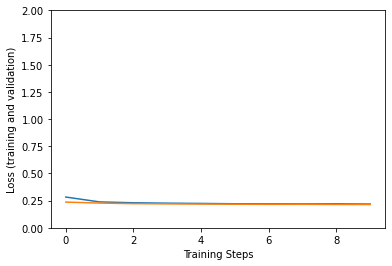

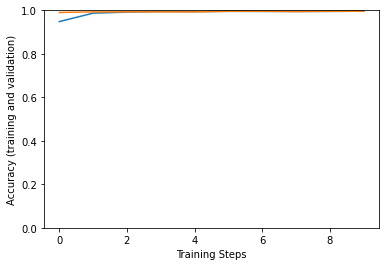

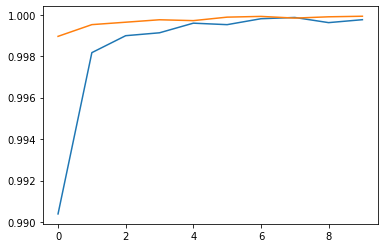

<Figure size 432x288 with 0 Axes>

In [21]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])

plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
# plt.plot([a+0.5 for a in hist["val_loss"]])
plt.figure()

plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.figure()

plt.plot(hist["auc"])
plt.plot(hist["val_auc"])
plt.figure()

In [22]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

### Export and reload the model 
export the model as a SavedModel for reusing it later.

In [23]:
os.makedirs('./tmp/saved_models/',exist_ok=True)

In [24]:
# t = time.time()

export_path = "/tmp/saved_models/WildFireDetectionModel001"
model.save(export_path)

export_path

INFO:tensorflow:Assets written to: /tmp/saved_models/WildFireDetectionModel001/assets


INFO:tensorflow:Assets written to: /tmp/saved_models/WildFireDetectionModel001/assets


'/tmp/saved_models/WildFireDetectionModel001'

### scoring example from tf  
https://github.com/tensorflow/hub/blob/master/examples/colab/tf2_image_retraining.ipynb  

(-0.5, 223.5, 223.5, -0.5)

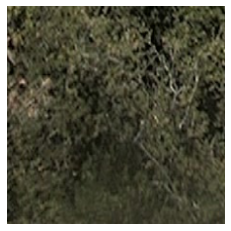

1/1 [==============================] - 1s 978ms/step
True label: grid_no_smoke
Predicted label: grid_no_smoke


In [25]:
x, y = next(iter(val_ds))
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + class_names[true_index])
print("Predicted label: " + class_names[predicted_index])

In [26]:
# type(((image, label) 
#                     for batch in val_ds
#                     for (image, label) in zip(*batch)))

In [27]:
def score_eval_examples(num_eval_examples):
    eval_dataset = ((image, label) 
                    for batch in val_ds
                    for (image, label) in zip(*batch))

    list_predictions=[]
    list_prediction_proba=[]
    list_labels=[]
    count = 0
    for image, label in eval_dataset:
        count +=1
        if count > num_eval_examples: break
        prediction_scores = probability_model.predict(np.expand_dims(image, axis=0))
        print(prediction_scores, label.numpy()[1])

        list_labels.append(label.numpy()[1])
        list_predictions.append(np.argmax(prediction_scores[0]))
        list_prediction_proba.append( prediction_scores[0][1])
        
    return list_labels,list_predictions,list_prediction_proba

In [28]:
%%capture longcelloutput

list_labels, list_predictions, list_prediction_proba = score_eval_examples(500)


In [29]:
del longcelloutput
list_labels[0:2]
list_predictions[0:2]
list_prediction_proba[0:2]

[1.0, 0.0]

[1, 0]

[0.9709562, 0.050201543]

In [30]:
if False:
    list_predictions=[]
    list_prediction_proba=[]
    list_labels=[]
    for i in range(20):
        x, y = next(iter(val_ds))
        for counterInsideBatch in range(BATCH_SIZE):
            # print(listPredictions, list_labels)
            image = x[counterInsideBatch, :, :, :]
            # x.shape

#             true_index = np.argmax(y[0])
#             plt.imshow(image)
#             plt.axis('off')
#             plt.show()

            # Expand the validation image to (1, 224, 224, 3) before predicting the label
            prediction_scores = probability_model.predict(np.expand_dims(image, axis=0))
            prediction_scores
            predicted_index = np.argmax(prediction_scores)
            # predicted_index
            predicted_proba = prediction_scores[0][1]
            predicted_proba
            # predicted_proba
            true_index = np.argmax(y[counterInsideBatch])
            # print("True label: " + class_names[true_index])
            list_labels.append(np.argmax(y[counterInsideBatch]))
            # print("Predicted label: " + class_names[predicted_index])
            list_predictions.append(predicted_index)
            list_prediction_proba.append(predicted_proba)

    # list_predictions, list_labels
    list_prediction_proba

In [31]:

# true_index = np.argmax(y[0])
# plt.imshow(image)
# plt.axis('off')
# plt.show()

In [32]:
accuracy_score(list_predictions, list_labels)
confusion_matrix(list_predictions, list_labels)
class_names[0]
class_names[1]
np.sum(np.array(list_labels))

0.996

array([[354,   2],
       [  0, 144]])

'grid_no_smoke'

'grid_smoke'

146.0

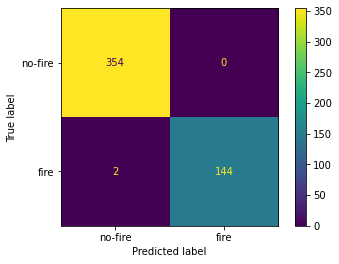

In [33]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(list_labels, list_predictions)
cmd = ConfusionMatrixDisplay(cm, display_labels=['no-fire','fire'])
cmd.plot()

In [34]:
fpr, tpr, thresholds = roc_curve(list_labels, list_prediction_proba)

# aa = (list_prediction_proba)
# aa.sort()
# print(aa)
fpr, tpr, thresholds 

roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

(array([0.        , 0.        , 0.        , 0.00282486, 0.00282486,
        1.        ]),
 array([0.        , 0.00684932, 0.99315068, 0.99315068, 1.        ,
        1.        ]),
 array([1.996381  , 0.9963811 , 0.45200953, 0.34866458, 0.2936043 ,
        0.02425554], dtype=float32))

Area under the ROC curve : 0.999981


(0.0, 1.0)

(0.0, 1.0)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Receiver operating characteristic')

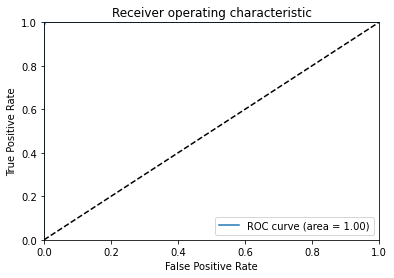

In [35]:
# Plot ROC curve
import pylab as pl
pl.clf()
pl.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Receiver operating characteristic')
pl.legend(loc="lower right")
pl.show()

In [36]:
# saved_model_path = f"/tmp/saved_wildfire_model_{model_name}"
# tf.saved_model.save(model, saved_model_path)

In [37]:
# num_eval_examples = 50 
# eval_dataset = ((image, label)  # TFLite expects batch size 1.
#                 for batch in train_ds
#                 for (image, label) in zip(*batch))
# count = 0
# count_lite_tf_agree = 0
# count_lite_correct = 0
# for image, label in eval_dataset:
#   probs_lite = lite_model(image[None, ...])[0]
#   probs_tf = model(image[None, ...]).numpy()[0]
#   y_lite = np.argmax(probs_lite)
#   y_tf = np.argmax(probs_tf)
#   y_true = np.argmax(label)
#   count +=1
#   if y_lite == y_tf: count_lite_tf_agree += 1
#   if y_lite == y_true: count_lite_correct += 1
#   if count >= num_eval_examples: break
# print("TFLite model agrees with original model on %d of %d examples (%g%%)." %
#       (count_lite_tf_agree, count, 100.0 * count_lite_tf_agree / count))
# print("TFLite model is accurate on %d of %d examples (%g%%)." %
#       (count_lite_correct, count, 100.0 * count_lite_correct / count))